### Домашнее задание 4.3.
Дано: API (http://api.football-data.org/docs/v1/index.html) для данных о футбольных матчах и командах
Используя kmeans:
* сделать кластеризацию футбольных команд:
    * по стоимости и 
    * по количеству проигрышей, 
* результат отобразить в виде точечного графика для случая
    * из 3 и 
    * из 5 кластеров

Стандартные настройки

In [58]:
import requests

import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from scipy.cluster.vq import whiten, kmeans2

Вспомогательный метод для обращения к API

In [9]:
def call_api(uri, result_key):
    json = {}
    try:
        json = requests.get(uri, headers = { 'X-Auth-Token': 'c1d91727866642669626d52c039c78f6' }).json()
        return json[result_key]
    except:
        print(json)
        return None

Получаем команды

In [11]:
teams = call_api('http://api.football-data.org/v1/soccerseasons/439/teams', 'teams')
teams

[{'_links': {'fixtures': {'href': 'http://api.football-data.org/v1/teams/496/fixtures'},
   'players': {'href': 'http://api.football-data.org/v1/teams/496/players'},
   'self': {'href': 'http://api.football-data.org/v1/teams/496'}},
  'code': None,
  'crestUrl': 'http://upload.wikimedia.org/wikipedia/de/6/63/Rio_Ave_FC.svg',
  'name': 'FC Rio Ave',
  'shortName': 'Rio Ave',
  'squadMarketValue': '21,125,000 €'},
 {'_links': {'fixtures': {'href': 'http://api.football-data.org/v1/teams/503/fixtures'},
   'players': {'href': 'http://api.football-data.org/v1/teams/503/players'},
   'self': {'href': 'http://api.football-data.org/v1/teams/503'}},
  'code': 'FCP',
  'crestUrl': 'http://upload.wikimedia.org/wikipedia/de/e/ed/FC_Porto_1922-2005.svg',
  'name': 'FC Porto',
  'shortName': 'Porto',
  'squadMarketValue': '204,900,000 €'},
 {'_links': {'fixtures': {'href': 'http://api.football-data.org/v1/teams/583/fixtures'},
   'players': {'href': 'http://api.football-data.org/v1/teams/583/players

Для каждой команды получаем стоимость команд и количество проигрышей
* Исключаем из стоимости символ "евро".
* Констатирована проблема - отсутствие по двум командам декларации о стоимости. Решено присвоить стоимость 0.

In [81]:
for team in teams:
    cost = team['squadMarketValue']
    if cost is not None:
        cost = re.findall(r'\d+',cost)
        cost =int(''.join(cost))
    else: cost = 0
    fixtures = call_api(team['_links']['fixtures']['href'], 'fixtures')
    lost = 0
    for f in fixtures:
        if f['result']['goalsAwayTeam'] is not None:
            if f['result']['goalsHomeTeam'] is not None:
                if team['name'] == f['homeTeamName']:
                    if f['result']['goalsHomeTeam'] < f['result']['goalsAwayTeam']:
                        lost += 1
                elif team['name'] == f['awayTeamName']:
                    if f['result']['goalsHomeTeam'] > f['result']['goalsAwayTeam']:
                       lost += 1
                else:
                    lost += 0
    print('Team "{}", cost {} , {} lost'.format(team['name'], cost, lost))
    team['cost'] = cost
    team['lost'] = lost

Team "FC Rio Ave", cost 21125000 , 11 lost
Team "FC Porto", cost 204900000 , 4 lost
Team "Moreirense FC", cost 9950000 , 15 lost
Team "FC Paços de Ferreira", cost 17725000 , 12 lost
Team "Sporting CP", cost 220250000 , 9 lost
Team "Maritimo Funchal", cost 18275000 , 8 lost
Team "CD Tondela", cost 11575000 , 15 lost
Team "SL Benfica", cost 180150000 , 5 lost
Team "Boavista Porto FC", cost 14025000 , 8 lost
Team "FC Arouca", cost 18025000 , 15 lost
Team "Vitoria Setubal", cost 21200000 , 11 lost
Team "C.F. Os Belenenses", cost 23650000 , 10 lost
Team "Vitoria Guimaraes", cost 32850000 , 6 lost
Team "Sporting Braga", cost 63800000 , 6 lost
Team "GD Estoril Praia", cost 12950000 , 14 lost
Team "Feirense", cost 0 , 12 lost
Team "Nacional Funchal", cost 21925000 , 16 lost
Team "G.D. Chaves", cost 0 , 7 lost


In [82]:
team_for_pd = []
for team in teams:
    team_for_pd.append({'name': team['name'], 'cost': team['cost'], 'lost': team['lost']})
team_for_pd

[{'cost': 21125000, 'lost': 11, 'name': 'FC Rio Ave'},
 {'cost': 204900000, 'lost': 4, 'name': 'FC Porto'},
 {'cost': 9950000, 'lost': 15, 'name': 'Moreirense FC'},
 {'cost': 17725000, 'lost': 12, 'name': 'FC Paços de Ferreira'},
 {'cost': 220250000, 'lost': 9, 'name': 'Sporting CP'},
 {'cost': 18275000, 'lost': 8, 'name': 'Maritimo Funchal'},
 {'cost': 11575000, 'lost': 15, 'name': 'CD Tondela'},
 {'cost': 180150000, 'lost': 5, 'name': 'SL Benfica'},
 {'cost': 14025000, 'lost': 8, 'name': 'Boavista Porto FC'},
 {'cost': 18025000, 'lost': 15, 'name': 'FC Arouca'},
 {'cost': 21200000, 'lost': 11, 'name': 'Vitoria Setubal'},
 {'cost': 23650000, 'lost': 10, 'name': 'C.F. Os Belenenses'},
 {'cost': 32850000, 'lost': 6, 'name': 'Vitoria Guimaraes'},
 {'cost': 63800000, 'lost': 6, 'name': 'Sporting Braga'},
 {'cost': 12950000, 'lost': 14, 'name': 'GD Estoril Praia'},
 {'cost': 0, 'lost': 12, 'name': 'Feirense'},
 {'cost': 21925000, 'lost': 16, 'name': 'Nacional Funchal'},
 {'cost': 0, 'lost'

Трансформируем

In [83]:
teams_pd = pd.DataFrame(team_for_pd)
teams_pd

,cost,lost,name
0,21125000,11,FC Rio Ave
1,204900000,4,FC Porto
2,9950000,15,Moreirense FC
3,17725000,12,FC Paços de Ferreira
4,220250000,9,Sporting CP
5,18275000,8,Maritimo Funchal
6,11575000,15,CD Tondela
7,180150000,5,SL Benfica
8,14025000,8,Boavista Porto FC
9,18025000,15,FC Arouca


Отображаем общую ситуацию

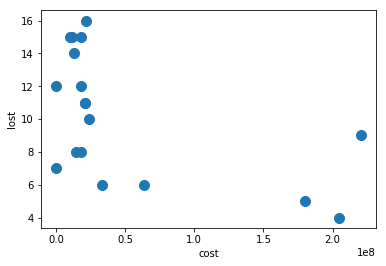

In [84]:
teams_pd.plot.scatter(x='cost', y='lost', s=100)

Удаляем колонку с именами

In [85]:
del teams_pd['name']
teams_pd

,cost,lost
0,21125000,11
1,204900000,4
2,9950000,15
3,17725000,12
4,220250000,9
5,18275000,8
6,11575000,15
7,180150000,5
8,14025000,8
9,18025000,15


Нормализация данных

In [86]:
whitened = whiten(teams_pd.as_matrix())
whitened

array([[ 0.30322776,  2.96881271],
       [ 2.94112982,  1.07956826],
       [ 0.14282207,  4.04838097],
       [ 0.25442424,  3.23870478],
       [ 3.16146336,  2.42902858],
       [ 0.26231892,  2.15913652],
       [ 0.16614728,  4.04838097],
       [ 2.5858689 ,  1.34946032],
       [ 0.20131452,  2.15913652],
       [ 0.25873043,  4.04838097],
       [ 0.30430431,  2.96881271],
       [ 0.33947155,  2.69892065],
       [ 0.47152813,  1.61935239],
       [ 0.91578371,  1.61935239],
       [ 0.185884  ,  3.77848891],
       [ 0.        ,  3.23870478],
       [ 0.31471094,  4.31827304],
       [ 0.        ,  1.88924445]])

Создаем три кластера 

In [87]:
centroids, cluster_map = kmeans2(whitened, 3)
centroids, cluster_map

(array([[ 2.89615403,  1.61935239],
        [ 0.21447233,  3.62854887],
        [ 0.36506947,  2.02419049]]),
 array([1, 0, 1, 1, 0, 2, 1, 0, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2], dtype=int32))

Задаем цвета для каждого кластера

In [88]:
colors_map = {0: 'r', 1: 'g', 2: 'b', 3: 'y', 4: 'm'}
colors = [colors_map[c] for c in cluster_map]
colors

['g',
 'r',
 'g',
 'g',
 'r',
 'b',
 'g',
 'r',
 'b',
 'g',
 'g',
 'b',
 'b',
 'b',
 'g',
 'g',
 'g',
 'b']

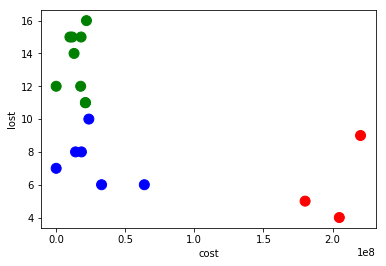

In [89]:
teams_pd.plot.scatter(x='cost', y='lost', c=colors, s=100)

Создаем 5 кластеров

In [95]:
centroids, cluster_map = kmeans2(whitened, 5)
centroids, cluster_map

(array([[ 0.69365592,  1.61935239],
        [ 0.21365894,  4.04838097],
        [ 2.89615403,  1.61935239],
        [ 0.24028557,  3.02279113],
        [ 0.15454448,  2.0691725 ]]),
 array([3, 2, 1, 3, 2, 4, 1, 2, 4, 1, 3, 3, 0, 0, 1, 3, 1, 4], dtype=int32))

In [96]:
colors_map = {0: 'r', 1: 'g', 2: 'b', 3: 'y', 4: 'm'}
colors = [colors_map[c] for c in cluster_map]
colors

['y',
 'b',
 'g',
 'y',
 'b',
 'm',
 'g',
 'b',
 'm',
 'g',
 'y',
 'y',
 'r',
 'r',
 'g',
 'y',
 'g',
 'm']

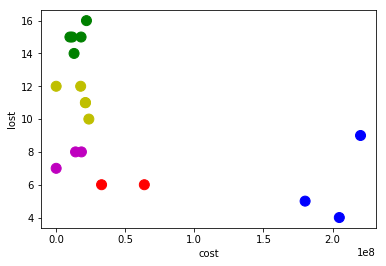

In [97]:
teams_pd.plot.scatter(x='cost', y='lost', c=colors, s=100)